# PFLD model 적용 테스트

본 테스트는 기존 VSAAS(http://10.51.11.12:8000/AI-Challenge/MLS)에 적용되어 있었던 MTCNN의 landmark 추출 기능을 대신하여 보다 나은 성능을 보이는 PFLD 모델을 적용하는 과정을 확인하기 위하여 작성되었다.
(참고: https://github.com/attodev/AI/tree/main/FaceAligner)


기존의 MTCNN의 랜드마크 추출 기능을 대신하여 PFLD 모델을 적용하기 위하여 필요한 사항들을 정리하면 다음과 같다.

[변경 요구 사항]

- VSASS의 동작 과정은 입력된 이미지(1920*1080)에서 MTCNN 모델을 통해서 Face detection과 Face align을 위한 landmark 추출과정이 이루어진다.

- 적용하고자 하는 PFLD 모델은 얼굴 중심으로 잘라진 112*112 이미지를 텐서로 변환한 값을 입력으로 받는다.

- PFLD 모델의 출력값은 112*112 이미지 기준의 랜드마크이기 때문에, 이를 원본 이미지(1920*1080) 기준의 좌표로 변환해야 한다.

[테스트 사항]

1. PFLD face landmark 모델에 입력값으로 넣기 위하여 MTCNN detector에서 탐지한 얼굴의 바운딩 박스를 이용하여 얼굴 중심으로 크랍한 이미지를 생성하고, 이를 112*112 텐서로 변환

2. PFLD 모델의 결과값으로 얼굴의 68개의 랜드마크가 생성되는데, 68개 점을 VSASS에서 필요한 다섯 개점의 랜드마크로 변환

3. 2번 과정에서 변환된 랜드마크를 원본 이미지 해상도(1920*1080)기준의 좌표로 변환


## face_model.py

In [1]:
import os
import logging

import cv2
import numpy as np
import tensorrt as trt
import torch.backends.cudnn as cudnn
import torch
from torchvision import transforms
from PIL import Image
from facenet_pytorch import MTCNN
from skimage import transform as trans
from models.trt_utils import do_inference, allocate_buffers
from models.PFLD import PFLDInference

from matplotlib import pyplot as plt


class Detector():
    """ Face Detector

    Args:
        images: `list` of `numpy array`, RGB images
    
    Returns:
        bboxes_list: `list` of bounding boxes, [left, top, right, bottom]
        scores_list: `list` of confidence rates, float
    """

    def __init__(self):
        pass
    
    def preprocess(self, images):
        pass

    def detect(self, images):
        pass

class Aligner():
    """ Face Aligner

    Args:
        images: `list` of `numpy array`, RGB images
        faces_list: `list` of bounding boxes per image

    Returns:
        landmarks_list: `list` of landmarks per image, [x, y]
    """
    
    def __init__(self):
        pass

    def preprocess(self, image, face_area_list):
        pass

    def align(self, image, face_area_list):
        pass

class Recognizer():
    """ Face Recognizer

    Args:
        images: `list` of `numpy array`, RGB images
        faces_list: `list` of bounding boxes per image
        landmarks_list: `list` of landmarks per faces per image
    
    Returns:
        embeddings_list: `list` of face embeddings per image
    """

    def __init__(self):
        pass
    
    def preprocess(self, images, faces_list, landmarks_list):
        pass

    def recognize(self, images, faces_list, landmarks_list):
        pass
        
class MtcnnPTDetector(Detector):
    def __init__(self, 
                 thresholds=[0.6, 0.7, 0.7],
                 factor=0.709,
                 select_largest=True,
                 trim_margin=0.15, detect_min_width=20,
                 device='cuda:0'):
        
        self.model = MTCNN(thresholds=thresholds, factor=factor, select_largest=select_largest,
                            min_face_size=int(detect_min_width/2), device=device, post_process=False)
        
        self.landmarks_list = []
        self.trim_margin = trim_margin
        self.detect_min_width = detect_min_width
    
    def preprocess(self, images):
        return images
    
    def detect(self, images):
        bboxes_list_, scores_list_, landmarks_list_ = self.model.detect(images, landmarks=True)
        bboxes_list, scores_list, landmarks_list = [], [], []
        
        for image_, bboxes_, scores_, landmarks_ in zip(images, bboxes_list_, scores_list_, landmarks_list_):
            height, width, _ = image_.shape
            bboxes, scores, landmarks = [], [], []
            if bboxes_ is not None:
                for bbox, score, landmark in zip(bboxes_, scores_, landmarks_):
                    left, top, right, bottom = bbox
                    hmargin = (right - left) * self.trim_margin
                    wmargin = (bottom - top) * self.trim_margin
                    
                    left = int(max(0, left - wmargin))
                    top = int(max(0, top - hmargin))
                    right = int(min(width, right + wmargin))
                    bottom = int(min(height, bottom + hmargin))
                    
                    if (right - left) > self.detect_min_width:
                        bboxes.append([left, top, right, bottom])
                        scores.append(score)
                        landmarks.append(landmark.tolist())
                        
            bboxes_list.append(bboxes)
            scores_list.append(scores)
            landmarks_list.append(landmarks)
            
        self.landmarks_list = landmarks_list.copy()
        return bboxes_list, scores_list
    
    def align(self, images, faces_list):
        """ This function returns landmarks of the face returned from the detect function as it is.
            If you want to use it separately from detect, never call this function."""
        return self.landmarks_list
    
class PFLDAligner(Aligner):
    def __init__(self, model_path='../models/checkpoint.pth.tar'):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "CPU")
        self.checkpoint = torch.load(model_path, map_location = self.device)
        self.model = PFLDInference().to(self.device)
        self.model.load_state_dict(self.checkpoint['pfld_backbone'])
        self.model.eval()       # 

    def preprocess(self, image, face_area_list):
        height, width, _ = image.shape      # ex) 1080, 1920, 3
        faces = []
        Img = Image.fromarray(image)        # np array -> PIL image로 변환
        if face_area_list is not None:
            for face_area in face_area_list[0]:
                #left, top, right, bottom = face_area
                face_crop = Img.crop(face_area)     # 얼굴 크랍한 PIL 이미지
                #face_crop = face_crop.resize((112,112))
                #face_crop = np.array(face_crop)     # np array로 변환 -> 필요 X
                faces.append(transforms.Compose([transforms.Resize((112,112)), transforms.ToTensor()])(face_crop)) # tensor로 변환하여 저장

        return faces

    def align(self, image, face_area_list):
        faces = self.preprocess(image, face_area_list)      # preprocess로 크랍된 얼굴 리스트 생성 [ndarray]
        landmarks = []
        for face, face_area in zip(faces, face_area_list[0]):
            face = face.to(self.device)
            _, landmark = self.model(face.unsqueeze(0))     # PFLD로 98 랜드마크 추출
            landmark = landmark.reshape(landmark.shape[0], -1, 2)
            landmark = np.array(landmark.tolist()).reshape(98,2)
            # 98 landmarks -> 5 landmarks
            landmark5 = np.zeros((5, 2), dtype=np.float32)
            landmark5[0] = (landmark[60] + landmark[64]) / 2
            landmark5[1] = (landmark[68] + landmark[72]) / 2
            landmark5[2] = landmark[54]
            landmark5[3] = landmark[76]
            landmark5[4] = landmark[82]                     
            
            ###### 112*112 -> 1920*1080 기준으로 좌표 변경 
            left, top, right, bottom = face_area
            for i in range(len(landmark5)):
                x, y = landmark5[i]
                landmark5[i][0] = face_area[0] + (face_area[2]-face_area[0])*x
                landmark5[i][1] = face_area[1] + (face_area[3]-face_area[1])*y
                
            landmarks.append(landmark5.tolist())
        
        return landmarks
    
    def align_cropped(self, image, face_area_list):
        faces = self.preprocess(image, face_area_list)      # preprocess로 크랍된 얼굴 리스트 생성 [ndarray]
        landmarks = []
        for face, face_area in zip(faces, face_area_list[0]):
            face = face.to(self.device)
            _, landmark = self.model(face.unsqueeze(0))     # PFLD로 98 랜드마크 추출
            landmark = landmark.reshape(landmark.shape[0], -1, 2)
            landmark = np.array(landmark.tolist()).reshape(98,2)
            # 98 landmarks -> 5 landmarks
            landmark5 = np.zeros((5, 2), dtype=np.float32)
            landmark5[0] = (landmark[60] + landmark[64]) / 2
            landmark5[1] = (landmark[68] + landmark[72]) / 2
            landmark5[2] = landmark[54]
            landmark5[3] = landmark[76]
            landmark5[4] = landmark[82]                     
            landmarks.append(landmark5.tolist())
        
        return landmarks


class ArcfaceTRTRecognizer(Recognizer):
    def __init__(self, model_path='../models/arcface-dynamic.trt',
                 batch_size=32):
        
        self.batch_size = batch_size
        self.image_size = 112
        self.src = np.array([[38.2946, 51.6963], [73.5318, 51.5014], [56.0252, 71.7366],
                             [41.5493, 92.3655], [70.7299, 92.2041]], dtype=np.float32)
        
        runtime = trt.Runtime(trt.Logger())
        with open(model_path, "rb") as f:
            engine = runtime.deserialize_cuda_engine(f.read())
            
        self.context = engine.create_execution_context()
        self.inputs, self.outputs, self.bindings, self.stream = allocate_buffers(engine, self.batch_size)
        self.context.set_binding_shape(0, (self.batch_size, 3, self.image_size, self.image_size))
        
    def preprocess(self, images, faces_list, landmarks_list):
        """ Extract face image from original image based on the landmark. 
            Normalization((x-127.5)/128) is conducted by model so dosen't needed.
        """
        num_faces = list(map(lambda x: len(x), faces_list))

        face_images = []
        for image, faces, landmarks in zip(images, faces_list, landmarks_list):
            for face, landmark in zip(faces, landmarks):
                tmp = image.copy()
                
                landmark = np.array(landmark)
                landmark5 = np.zeros((5, 2), dtype=np.float32)
                if len(landmark) == 5:
                    landmark5 = landmark
                else: # 68-landmark
                    landmark5[0] = (landmark[36] + landmark[39]) / 2
                    landmark5[1] = (landmark[42] + landmark[45]) / 2
                    landmark5[2] = landmark[30]
                    landmark5[3] = landmark[48]
                    landmark5[4] = landmark[54]
                
                tform = trans.SimilarityTransform()
                tform.estimate(landmark5, self.src)
                M = tform.params[0:2, :]
                tmp = cv2.warpAffine(tmp, M, (self.image_size, self.image_size), borderValue=0.0)
                tmp = np.transpose(tmp, (2, 0, 1))
                face_images.append(tmp)

        face_images = np.ascontiguousarray(face_images).astype('float32')
        
        return face_images, num_faces
    
    def recognize(self, images, faces_list, landmarks_list):
        face_images, num_faces = self.preprocess(images, faces_list, landmarks_list)
        flat_embeddings = []
        for i in range(0, len(face_images), self.batch_size):
            faces = face_images[i:i+self.batch_size]
            self.inputs[0].host = faces
            trt_outputs = do_inference(self.context, self.bindings, self.inputs, self.outputs, self.stream)
            emb = trt_outputs[0].reshape(self.batch_size, -1)
            norm = np.linalg.norm(emb, axis=1).reshape((-1, 1))
            emb /= norm
            flat_embeddings += emb.tolist()
        
        embeddings_list = []
        start = 0
        for num in num_faces:
            embeddings_list.append(flat_embeddings[start:start+num])
            start += num
        
        return embeddings_list
    

## 1. 얼굴 이미지 자르기 테스트

-  PFLD face landmark 모델에 입력값으로 넣기 위하여 MTCNN detector에서 탐지한 얼굴의 바운딩 박스를 이용하여 얼굴 중심으로 크랍한 이미지를 생성

원본 이미지 (1920*1080)

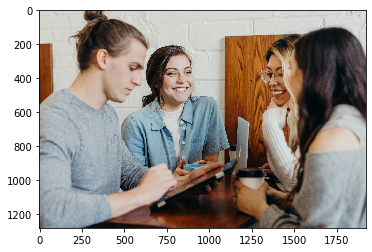

In [2]:
img = Image.open("../images/img1.png").convert('RGB')
plt.imshow(img)

### 테스트 결과

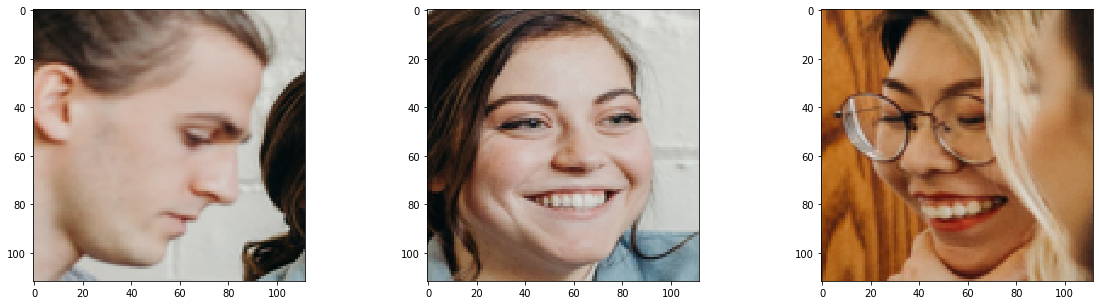

In [3]:
if __name__ == "__main__":
    img = Image.open("../images/img1.png").convert('RGB')
    img = np.array(img)
    face_area_list, _ = MtcnnPTDetector().detect([img])   # 얼굴 바운딩 박스 추출
    ### 얼굴 중심으로 자르기
    faces = []
    pilimg = Image.fromarray(img)
    for face_area in face_area_list[0]:
        face_crop = pilimg.crop(face_area)
        face_crop = face_crop.resize((112, 112))
        faces.append(face_crop)
    ### Visualisation
    fig = plt.figure(figsize=(20, 5))
    subplot = 0
    for face in faces:
        subplot += 1
        ax = fig.add_subplot(1, len(faces), subplot)
        ax.imshow(face)

## 2. PFLD 랜드마크 추출 테스트
- PFLD 모델의 결과값으로 얼굴의 68개의 랜드마크가 생성되는데, 68개 점을 VSASS에서 필요한 다섯 개점의 랜드마크로 변환
- 1번 과정에서 생성한 크랍 이미지에 랜드마크 그리기


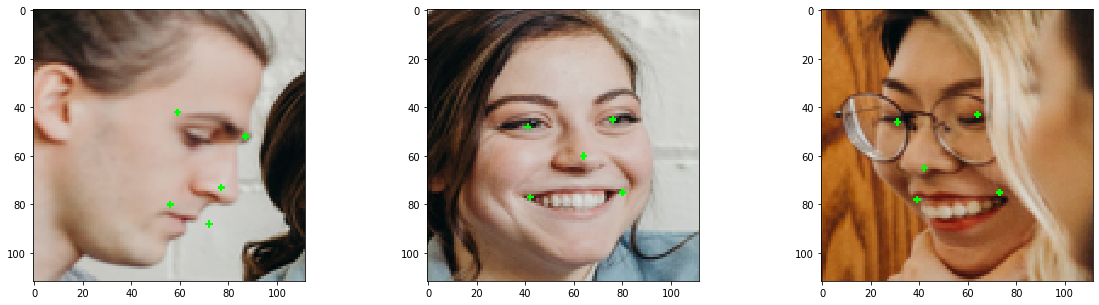

In [4]:
if __name__ == "__main__":
    img = Image.open("../images/img1.png").convert('RGB')
    img = np.array(img)
    face_area_list, _ = MtcnnPTDetector().detect([img])   # 얼굴 바운딩 박스 추출
    imgBGR = cv2.imread("../images/img1.png")
    landmarks = PFLDAligner().align_cropped(imgBGR, face_area_list)
    ### 얼굴 중심으로 자르기
    faces = []
    pilimg = Image.fromarray(img)
    for face_area in face_area_list[0]:
        face_crop = pilimg.crop(face_area)
        face_crop = face_crop.resize((112, 112))
        faces.append(face_crop)
    ### Visualisation
    fig = plt.figure(figsize=(20, 5))
    subplot = 0
    for face, landmark in zip(faces, landmarks):
        subplot += 1
        ax = fig.add_subplot(1, len(faces), subplot)
        face = np.array(face)
        for i in range(5):
            x, y = landmark[i]
            cv2.circle(face, (int(x*112), int(y*112)), 1, (0, 255, 0), -1)
        ax.imshow(face)

## 3. 랜드마크를 원본 이미지 해상도기준으로 변환
- PFLD 모델로 추출한 랜드마크를 원본 이미지에 그리기

### 테스트 결과

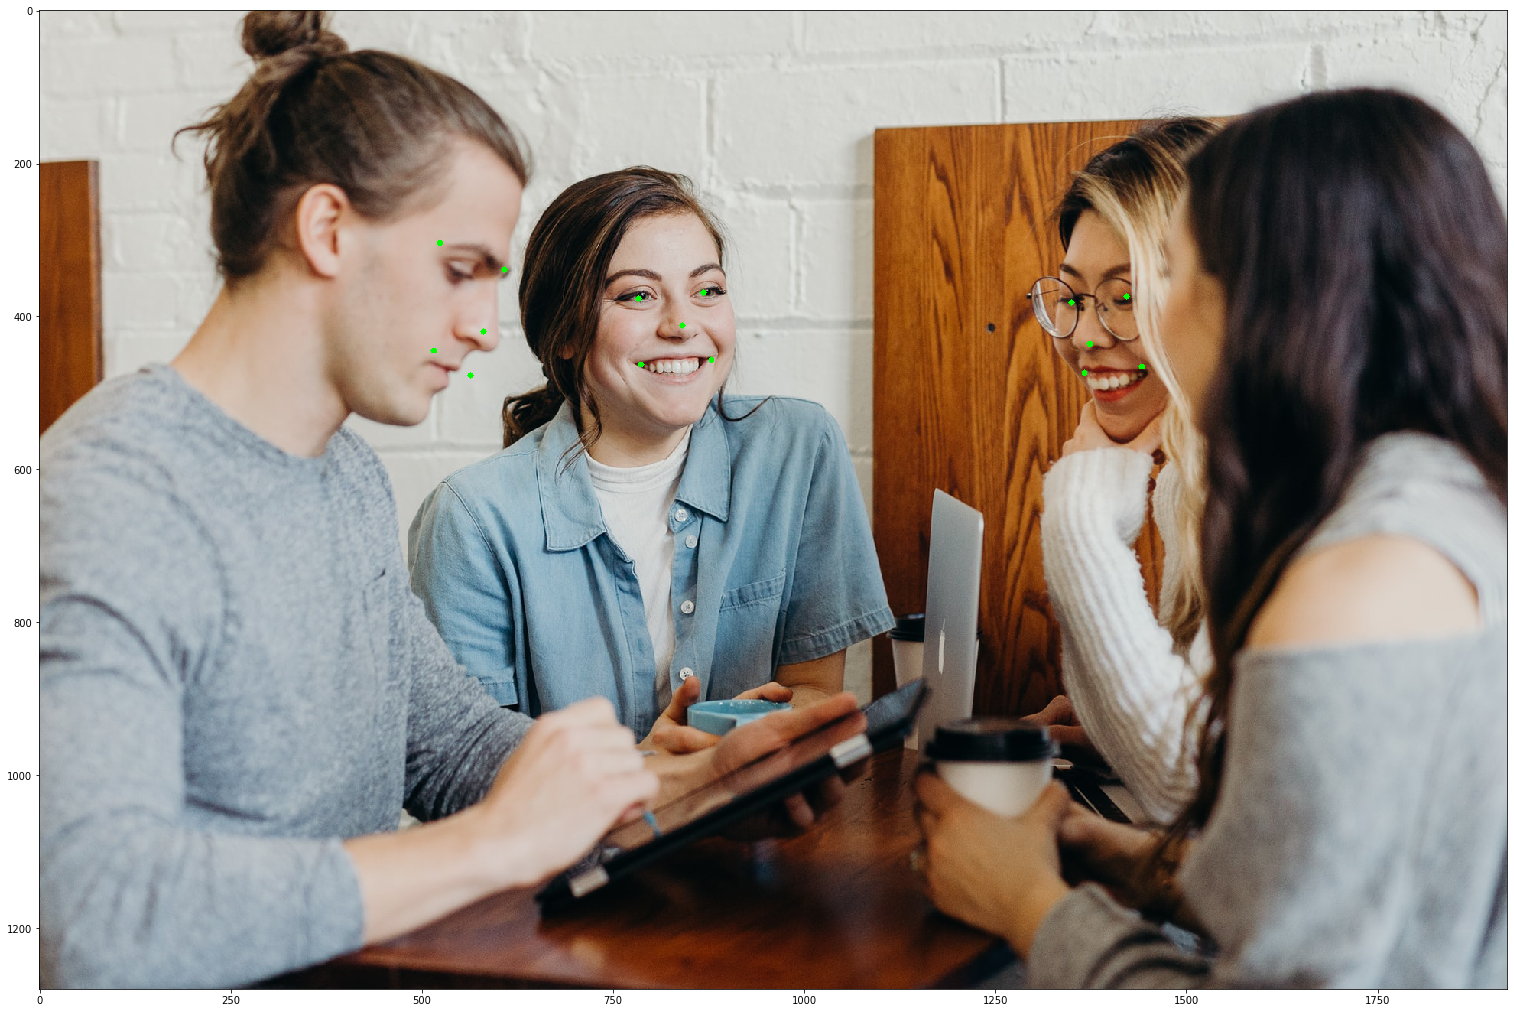

In [5]:
if __name__ == "__main__":
    img = Image.open("../images/img1.png").convert('RGB')
    img = np.array(img)
    face_area_list, _ = MtcnnPTDetector().detect([img])
    imgBGR = cv2.imread("../images/img1.png")
    landmarks = PFLDAligner().align(imgBGR, face_area_list)
    
    ### Draw landmarks on image.
    radius = img.shape[1] // 500 + 1

    for i in range(len(landmarks)):
        for l in range(5):
            x, y = landmarks[i][l]
            cv2.circle(img, (int(x), int(y)), radius, (0, 255, 0), -1)

    plt.figure(figsize=(32, 18))
    plt.imshow(img)